In [42]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Skipping, found downloaded files in "./animal-faces" (use force=True to force download)


In [43]:
import torch 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import torchvision.transforms as transforms
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device available: ", device)

Device available:  cuda


In [44]:
image_path = []
labels = []

for i in os.listdir("animal-faces/afhq"):
    for label in os.listdir(f"animal-faces/afhq/{i}"):
        for image in os.listdir(f"animal-faces/afhq/{i}/{label}"):
            image_path.append(f"animal-faces/afhq/{i}/{label}/{image}")
            labels.append(label)

data_df = pd.DataFrame(zip(image_path, labels), columns=["image_path", "labels"])
print(data_df["labels"].unique())
data_df.head()

['cat' 'wild' 'dog']


,image_path,labels
0,animal-faces/afhq/val/cat/flickr_cat_000554.jpg,cat
1,animal-faces/afhq/val/cat/flickr_cat_000162.jpg,cat
2,animal-faces/afhq/val/cat/pixabay_cat_002138.jpg,cat
3,animal-faces/afhq/val/cat/pixabay_cat_003016.jpg,cat
4,animal-faces/afhq/val/cat/pixabay_cat_003986.jpg,cat


In [45]:
train = data_df.sample(frac=0.7)
test = data_df.drop(train.index)

val = test.sample(frac=0.5)
test = test.drop(val.index)

print(train.shape)
print(val.shape)
print(test.shape)

(11291, 2)
(2420, 2)
(2419, 2)


In [46]:
label_encoder = LabelEncoder()
label_encoder.fit(data_df["labels"])

transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [47]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, label_encoder, transforms = None):
        self.dataframe = dataframe
        self.transform = transforms
        self.labels = torch.tensor(label_encoder.transform(dataframe['labels'])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image).to(device)

        return image, label

In [48]:
train_dataset = CustomImageDataset(dataframe=train, label_encoder=label_encoder, transforms=transforms)
val_dataset = CustomImageDataset(dataframe=val, label_encoder=label_encoder, transforms=transforms)
test_dataset = CustomImageDataset(dataframe=test, label_encoder=label_encoder, transforms=transforms)

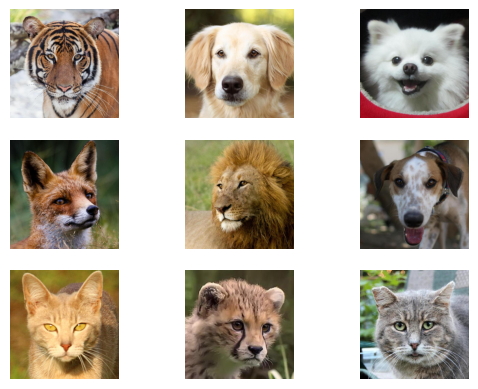

In [49]:
n_rows = 3
n_cols = 3

f, axarr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
    for col in range(n_cols):
        image = Image.open(data_df.sample(n=1)["image_path"].iloc[0]).convert("RGB")
        axarr[row, col].imshow(image)
        axarr[row, col].axis('off')

plt.show()

In [50]:
lr = 1e-4
batch_size = 16
epochs = 10

In [51]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [52]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pooling = nn.MaxPool2d(2, 2)

        self.relu = nn.ReLU()

        self.flatten = nn.Flatten()
        self.linear = nn.Linear((128*16*16), 128)

        self.output = nn.Linear(128, len(data_df['labels'].unique()))

    def forward(self, x):
        x = self.conv1(x) # -> (32, 128, 128)
        x = self.pooling(x) # -> (32, 64, 64)
        x = self.relu(x) # -> (32, 64, 64)

        x = self.conv2(x) # -> (64, 64, 64)
        x = self.pooling(x) # -> (64, 32, 32)
        x = self.relu(x) # -> (64, 32, 32)

        x = self.conv3(x) # -> (128, 32, 32)
        x = self.pooling(x) # -> (128, 16, 16)
        x = self.relu(x) # -> (128, 16, 16)

        x = self.flatten(x) # -> (1, 128*16*16)
        x = self.linear(x) # -> (128*16*16, 128)
        x = self.output(x) # -> (128, 3)
        return x

model = Net().to(device)

In [53]:
summary(model, input_size = (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [54]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)

In [55]:
total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

for epoch in range(epochs):
    total_loss_train = 0
    total_loss_val = 0
    total_acc_train = 0
    total_acc_val = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item() * inputs.shape[0]

        train_loss.backward()

        train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
        total_acc_train += train_acc

        optimizer.step()
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item() * inputs.shape[0]

            val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
            total_acc_val += val_acc
            
    total_loss_train_plot.append(round(total_loss_train / len(train_dataset), 4))
    total_loss_val_plot.append(round(total_loss_val / len(val_dataset), 4))
    total_acc_train_plot.append(round(total_acc_train / len(train_dataset) * 100, 4))
    total_acc_val_plot.append(round(total_acc_val / len(val_dataset) * 100, 4))

    print(f'''
    Epoch no. {epoch+1} 
    Train Loss: {total_loss_train_plot[epoch]} 
    Train Accuracy {total_acc_train_plot[epoch]}
    Validation Loss: {total_loss_val_plot[epoch]}
    Validation Accuracy: {total_acc_val_plot[epoch]}
                ''')
    print("="*35)


    Epoch no. 1 
    Train Loss: 0.4722 
    Train Accuracy 80.0018
    Validation Loss: 0.2401
    Validation Accuracy: 91.5702
                

    Epoch no. 2 
    Train Loss: 0.1854 
    Train Accuracy 93.331
    Validation Loss: 0.1777
    Validation Accuracy: 93.9256
                

    Epoch no. 3 
    Train Loss: 0.1139 
    Train Accuracy 96.0322
    Validation Loss: 0.1376
    Validation Accuracy: 94.9587
                

    Epoch no. 4 
    Train Loss: 0.084 
    Train Accuracy 96.9179
    Validation Loss: 0.1397
    Validation Accuracy: 95.0413
                

    Epoch no. 5 
    Train Loss: 0.0593 
    Train Accuracy 98.0604
    Validation Loss: 0.1307
    Validation Accuracy: 95.2479
                

    Epoch no. 6 
    Train Loss: 0.0423 
    Train Accuracy 98.5121
    Validation Loss: 0.1351
    Validation Accuracy: 95.7438
                

    Epoch no. 7 
    Train Loss: 0.0277 
    Train Accuracy 99.0966
    Validation Loss: 0.1453
    Validation Accuracy

In [57]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0

    for inputs, labels in test_loader:
        predictions = model(inputs)

        test_acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
        total_acc_test += test_acc

        test_loss = criterion(predictions, labels)
        total_loss_test += test_loss.item() * inputs.shape[0]

    print(f"Accuracy {round(total_acc_test / len(test_dataset) * 100, 4)} and Loss {round(total_loss_test / len(test_dataset), 4)}")

Accuracy 95.742 and Loss 0.1435


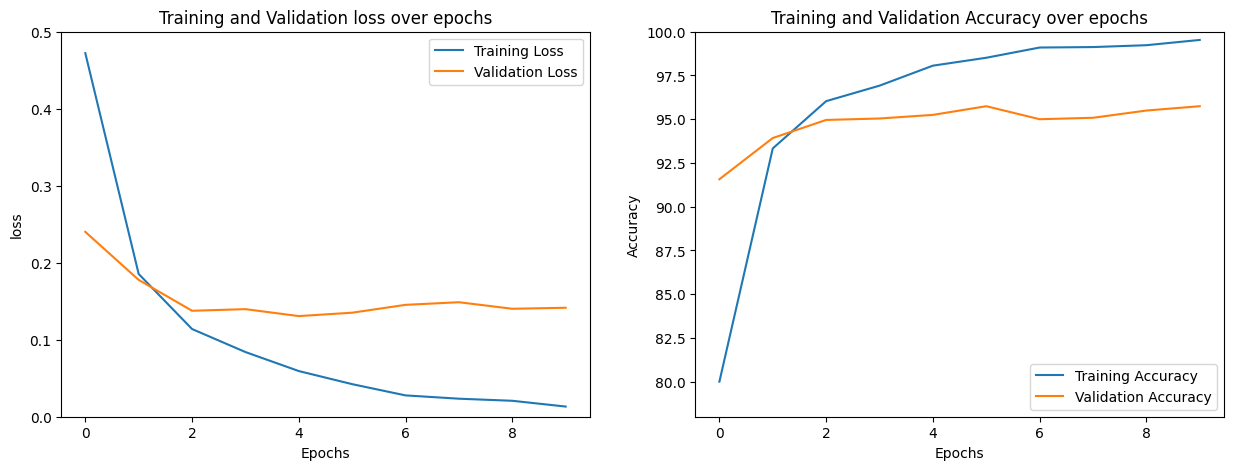

In [61]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axs[0].plot(total_loss_train_plot, label = 'Training Loss')
axs[0].plot(total_loss_val_plot, label = 'Validation Loss')
axs[0].set_title("Training and Validation loss over epochs")
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('loss')
axs[0].set_ylim([0, 0.5])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = 'Training Accuracy')
axs[1].plot(total_acc_val_plot, label = 'Validation Accuracy')
axs[1].set_title("Training and Validation Accuracy over epochs")
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([78, 100])
axs[1].legend()

plt.show()

In [69]:
def image_predict(image_path, transform):
    image = Image.open(image_path).convert("RGB")

    image = transform(image).to(device)
    print(image.shape)
    output = model(image.unsqueeze(0))

    output = torch.argmax(output, axis = 1).item()

    return label_encoder.inverse_transform([output]).item()
image_predict("animal-faces/afhq/myImg/Cat_August_2010-3.jpg", transforms)

torch.Size([3, 128, 128])


'cat'